#**Imports**

In [25]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import time
import PIL
import glob
from base64 import b64encode
import datetime
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision import models, transforms

from fastai.callbacks import hook_outputs
from fastai.torch_core import requires_grad, children

In [2]:
torch.backends.cudnn.deterministic = True 
# check if training using GPU is possible
torch.cuda.is_available()

True

In [3]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# folder, created in advance in the Google Drive and containing kaggle.json
#project_folder = "/content/gdrive/MyDrive/Kaggle/NaturalPainters" # for original email
project_folder = "/content/gdrive/MyDrive/NaturalPainters" 
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [5]:
# dive into folder
#%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters


In [6]:
# path to load the GAN generator
generator_path = project_folder + "/models/gan/GAN_generator_1e.pth"
# path to images amongst which you can choose what to draw
load_images_path = project_folder + '/source_images/*'
# path to save images that we eventually paint
save_images_path = project_folder + '/painted_images/'
# path to save painting loss
plots_path = project_folder + '/plots/'

In [7]:
# there are links to images that were taken from the reference github for the paper
# !wget -c https://github.com/reiinakano/neural-painters-pytorch/blob/master/images/vanc.jpg
# !wget -c https://github.com/reiinakano/neural-painters-pytorch/blob/master/images/louvre.png
# !wget -c https://github.com/reiinakano/neural-painters-pytorch/blob/master/images/eiffel.jpeg
# !wget -c https://github.com/reiinakano/neural-painters-pytorch/blob/master/images/castle.png

In [8]:
SEED = 4

# **Generator**

In [9]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
      super(Generator, self).__init__()

      self.out_features = img_height * img_width

      self.lin = nn.Linear(in_features, self.out_features)

      self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                      kernel_size = (4, 4), stride = (1, 1), bias = False)
      self.norm1 = nn.BatchNorm2d(num_features)

      self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm2 = nn.BatchNorm2d(num_features)

      self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm3 = nn.BatchNorm2d(num_features)

      self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm4 = nn.BatchNorm2d(num_features)

      self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                      kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
      self.norm5 = nn.BatchNorm2d(num_features)

      self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
      x = self.lin(x)
      x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
      x = self.norm1(x)
      x = F.relu(self.conv2(x), inplace = True)
      x = self.norm2(x)
      x = F.relu(self.conv3(x), inplace = True)
      x = self.norm3(x)
      x = F.relu(self.conv4(x), inplace = True)
      x = self.norm4(x)
      x = F.relu(self.conv5(x), inplace = True)
      x = self.norm5(x)

      return torch.tanh(self.conv6(x))

In [10]:
class FeatureExtractor(nn.Module):

    def __init__(self, 
                 layers_weights,
                 device):
      super(FeatureExtractor, self).__init__()
      
      self.layers_weights = layers_weights
      self.device = device
      self.feature_extractor, self.layers_indices = self.extractor()
      self.outputs = hook_outputs([self.feature_extractor[i] for i in self.layers_indices], detach = False)

    def extractor(self):
        print("Download VGG19 (batch normalized) as pre-trained.\n")
        if self.device == 'cuda':
            extractor = models.vgg19_bn(True).features.cuda().eval()
        else:
            extractor = models.vgg19_bn(True).features.eval()
        requires_grad(extractor, False)
        return extractor, [i - 1 for i, layer in enumerate(children(extractor)) if isinstance(layer, nn.MaxPool2d)][2:]

    def gram_matrix(self, input):

        (a, b, c, d) = input.size()
        features = input.view(a, b, c * d)
        G = features @ features.transpose(1, 2)
        return G.div(b * c * d)

    def forward(self, gen_stroke, true_stroke):

        self.feature_extractor(gen_stroke)
        gen_stroke_features = [out for out in self.outputs.stored]
        
        self.feature_extractor(true_stroke)
        true_stroke_features = [out.clone() for out in self.outputs.stored]

        self.loss = []
        
        feature_loss = [F.l1_loss(gen_layer, true_layer) * weight
                             for gen_layer, true_layer, weight 
                        in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
        

        style_loss = [F.l1_loss(self.gram_matrix(gen_layer), self.gram_matrix(true_layer)) * weight**2 * 5000
                             for gen_layer, true_layer, weight 
                      in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
    
        pixel_loss = [F.l1_loss(gen_stroke, true_stroke)]

        self.loss += feature_loss + style_loss + pixel_loss
                
        return sum(self.loss)

    def __del__(self):
        
        self.outputs.remove()

In [11]:
torch.manual_seed(SEED)
class Hparams():
    in_strokes = 50 #@param {type:"slider", min:8, max:1024, step:8}
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    layers_weights = [5, 15, 2] #@param
    batch_size = 128 #@param {type: "slider", min:8, max:512, step:8}
    lr = 0.01 #@param {type:"number"}
    epochs = 3000 #@param {type:"slider", min:1, max:4000, step:1}
    print_interval = 100 #@param {type:"slider", min:1, max:100, step:10}
    secs = 0.2 #@param {type:"slider", min:0.1, max:1.0, step:0.05}
hparams = Hparams()

gpu = torch.cuda.is_available()
if gpu:
    print("Training will be performed using GPU.\n")
    device = 'cuda'
else:
    print("Training will be performed using CPU.\n")
    device = 'cpu'

generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

feature_extractor = FeatureExtractor(hparams.layers_weights, device)

generator.load_state_dict(torch.load(generator_path, 
                                     map_location = torch.device(device)))

for param in generator.parameters():
    generator.requires_grad = False

generator.to(device).eval()                

Training will be performed using GPU.

Download VGG19 (batch normalized) as pre-trained.



Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Generator(
  (lin): Linear(in_features=12, out_features=4096, bias=True)
  (conv1): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

# **Blending**

In [12]:
def paint_image(gen_strokes, gpu, test_mode = False, save_path = '', stack_interval = 8):

        canvas_evolution = []

        # returns a tensor filled with the scalar value `1` (white), with the same size as gen_strokes[0]
        # so canvas is a white area of a size (3, 64, 64)
        canvas = torch.ones_like(gen_strokes[0], requires_grad = True, dtype = torch.float32)
        if test_mode:
            gen_strokes_h = torch.ones(([gen_strokes[0].shape[0], 
                                        gen_strokes[0].shape[1], 
                                        gen_strokes[0].shape[2] * stack_interval])).cpu()

        # iterating over num_strokes to paint
        for i, stroke in enumerate(gen_strokes):

            size = stroke.shape[1]

            # what we want to do is to calculate the “opacity” of an individual brush stroke pixel 
            # by computing how dark it is relative to the darkest pixel (full opacity) in the brush stroke

            # in the following lines we compute brush_color - the darkest value inside the channel
            # we iterate over 3 channels and image rows and compute for each row minimum (darkest) value in column - output is (3, 64)
            # then we iterate inside row and get the darkest color for each channel - output is 3 values
            # the values obtained can be out of interval [0, 1] (between black and white), therefore we force (clamp) them to this interval
            # we make reshape 3 -> (1, 3, 1, 1) - batch of one image with 3 channels of size (1, 1)
            # we expand the darkest value of channel for the full image size in this channel - output is (1, 3, 64, 64) 
            brush_color = stroke.min(1)[0].min(1)[0].clamp_(0, 1).view(-1, 3, 1, 1)
            brush_color = brush_color.expand(-1, 3, size, size)

            # get the "darkness" of each individual pixel in a stroke by averaging
            # in other words, each pixel is represented by 3 channels
            # we define darkness of a pixel as an average amongst its values in 3 channels - output is (64, 64)
            darkness_mask = torch.mean(stroke, 0)

            # make the value of a darker stroke higher
            # first we reshape mask from (64, 64) to (1, 1, 64, 64) to have the same niumber of dimensions as brush_stroke
            # originally the darker values are lower, by subtracting from 1, the darker values are higher
            # so, now, the closer to 1 - darker
            darkness_mask = 1 - torch.reshape(darkness_mask, (-1, 1, size, size))

            # scale this darkness mask from 0 to 1 by dividing each value in mask on the maximum possible in the mask
            darkness_mask = darkness_mask / torch.max(darkness_mask)

            # replace the original stroke with one that has all colored pixels set to the actual color used in two steps

            # step 1: boolean mask corresponding to the size of image (3, 64, 64) which if the value was 1 (white) contains True, otherwise False 
            stroke_whitespace = torch.eq(stroke, 1.)

            # step 2: if at the given coordinate in stroke there was white we will keep white,
            # if there was some another value - we take the darkest in this channel
            maxed_stroke = torch.where(stroke_whitespace, stroke, brush_color)

            if gpu:
                maxed_stroke = maxed_stroke.cuda()
                darkness_mask = darkness_mask.cuda()

            # linearly blend
            # that means that if the pixel of current stroke is dark, it has a large value and we keep mostly it + a little bit of canvas
            # if stroke pixel is light, then we take a little bit of it and mostly canvas value
            canvas = (darkness_mask) * maxed_stroke + (1 - darkness_mask) * canvas

            cur_canvas = to_pil_image(canvas.clone().cpu().squeeze())
            canvas_evolution.append(cur_canvas)

            if test_mode:
                print(f'Current stroke {i + 1}/{len(gen_strokes)} and canvas after adding it:\n')
                display(to_pil_image(torch.cat((stroke.clone().cpu(), canvas.clone().cpu().squeeze()), dim = 2)))
                if i == 0:
                    gen_strokes_w = canvas.clone().cpu().squeeze()
                elif i == stack_interval:
                    gen_strokes_h = gen_strokes_w.clone()
                    gen_strokes_w = canvas.clone().cpu().squeeze()
                elif i % stack_interval == 0:
                    gen_strokes_h = torch.cat((gen_strokes_h, gen_strokes_w), dim = 1)
                    gen_strokes_w = canvas.clone().cpu().squeeze()
                else:
                    gen_strokes_w = torch.cat((gen_strokes_w, canvas.clone().cpu().squeeze()), dim = 2)

        if save_path != '':
            print('\nBlending progress for the examples of the generated strokes:')
            gen_strokes_h = torch.cat((gen_strokes_h, gen_strokes_w), dim = 1)
            display(to_pil_image(gen_strokes_h))
            to_pil_image(gen_strokes_h).save(save_path, optimize = True, subsampling = 0, quality = 100)
            print(f"\nImage is saved to {save_path}.")

        return canvas, canvas_evolution


Current stroke 1/32 and canvas after adding it:



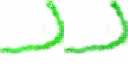

Current stroke 2/32 and canvas after adding it:



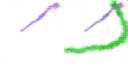

Current stroke 3/32 and canvas after adding it:



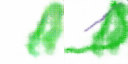

Current stroke 4/32 and canvas after adding it:



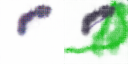

Current stroke 5/32 and canvas after adding it:



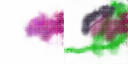

Current stroke 6/32 and canvas after adding it:



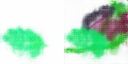

Current stroke 7/32 and canvas after adding it:



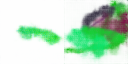

Current stroke 8/32 and canvas after adding it:



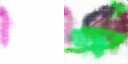

Current stroke 9/32 and canvas after adding it:



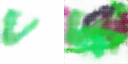

Current stroke 10/32 and canvas after adding it:



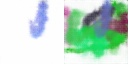

Current stroke 11/32 and canvas after adding it:



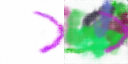

Current stroke 12/32 and canvas after adding it:



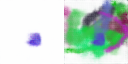

Current stroke 13/32 and canvas after adding it:



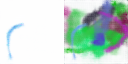

Current stroke 14/32 and canvas after adding it:



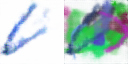

Current stroke 15/32 and canvas after adding it:



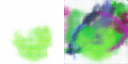

Current stroke 16/32 and canvas after adding it:



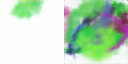

Current stroke 17/32 and canvas after adding it:



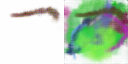

Current stroke 18/32 and canvas after adding it:



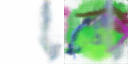

Current stroke 19/32 and canvas after adding it:



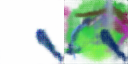

Current stroke 20/32 and canvas after adding it:



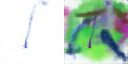

Current stroke 21/32 and canvas after adding it:



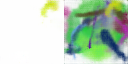

Current stroke 22/32 and canvas after adding it:



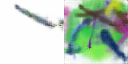

Current stroke 23/32 and canvas after adding it:



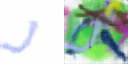

Current stroke 24/32 and canvas after adding it:



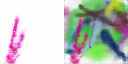

Current stroke 25/32 and canvas after adding it:



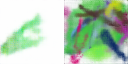

Current stroke 26/32 and canvas after adding it:



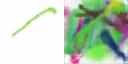

Current stroke 27/32 and canvas after adding it:



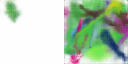

Current stroke 28/32 and canvas after adding it:



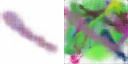

Current stroke 29/32 and canvas after adding it:



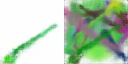

Current stroke 30/32 and canvas after adding it:



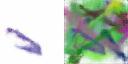

Current stroke 31/32 and canvas after adding it:



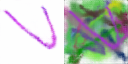

Current stroke 32/32 and canvas after adding it:



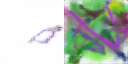


Blending progress for the examples of the generated strokes:


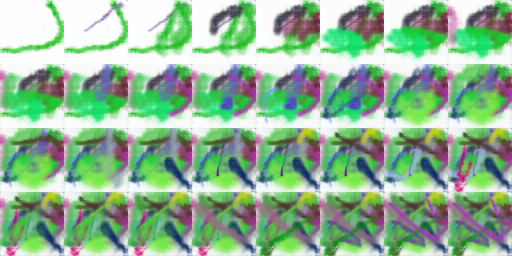


Image is saved to /content/gdrive/MyDrive/NaturalPainters/painted_images/blending.png.

Canvas is a tensor and has shape torch.Size([1, 3, 64, 64]).
Canvas evolution is a list and has a length 32.


In [13]:
# execute this cell if you would like to check blending before painting
def test_blending(npz, in_strokes, generator):

    data = np.load('strokes-dataset/' + npz)

    strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in data['strokes']])
    actions = torch.stack([torch.from_numpy(action).float() for action in data['actions']])

    dataset = TensorDataset(strokes, actions)

    dataloader = DataLoader(dataset, 
                            batch_size = in_strokes, 
                            shuffle = False)

    for (stroke, action) in dataloader:
        if next(generator.parameters()).is_cuda:
          action = action.cuda()
        gen_strokes = generator(action)
        break

    return paint_image(gen_strokes, next(generator.parameters()).is_cuda, 
                       test_mode = True, 
                       save_path = save_images_path + 'blending.png',
                       stack_interval = in_strokes // 4)
  

canvas, canvas_evolution = test_blending(npz = 'episodes_2.npz', in_strokes = 32, generator = generator)
print(f"\nCanvas is a tensor and has shape {canvas.shape}.")
print(f"Canvas evolution is a list and has a length {len(canvas_evolution)}.")

# **Loading image for painting**

In [14]:
def load_img(img_path, 
             thumb_size = None, 
             crop = 256, 
             out_size = None):

        img = PIL.Image.open(img_path)
    
        if thumb_size is not None:
            img.thumbnail((thumb_size, thumb_size), PIL.Image.ANTIALIAS)
            if (img.size[1] > crop) and (img.size[1] < (2 * crop)):
                img = transforms.CenterCrop(crop)(img)
        if out_size is not None:
            img = img.resize((out_size, out_size))

        return img

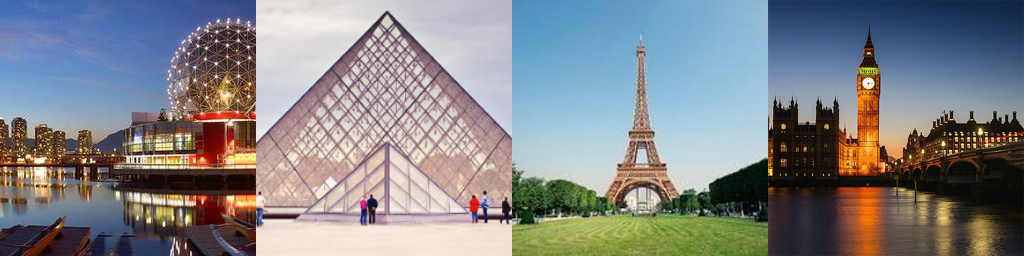

In [15]:
image_list = []
image_path_list = []
for i, img_path in enumerate(glob.glob(load_images_path)):
    img = load_img(img_path, thumb_size = 512, crop = 256, out_size = 256)
    image_list.append(img)
    image_path_list.append(img_path)

image_array = np.array(image_list[0])
for i in range(1, len(image_list)):
    image_array = np.hstack((image_array, np.array(image_list[i])))

source_images = PIL.Image.fromarray(image_array)
display(source_images)


Image to paint is an image of vanc:


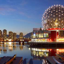


Image to paint is an image of louvre:


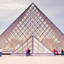


Image to paint is an image of eiffel:


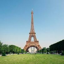


Image to paint is an image of castle:


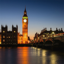


Each image tensor has size torch.Size([3, 64, 64])


In [16]:
# let's generate source content
def generate_source_to_paint(img_path):
    img_to_paint = load_img(img_path, thumb_size = 512, crop = 256, out_size = hparams.img_height)
    img_to_paint_name = img_path.split('/')[-1].split('.')[0]
    print(f"\nImage to paint is an image of {img_to_paint_name}:")
    display(img_to_paint)
    img_to_paint_tensor = to_tensor(img_to_paint).to(device)
    return img_to_paint_name, img_to_paint, img_to_paint_tensor

for img_path in image_path_list:
  img_to_paint_name, img_to_paint, img_to_paint_tensor = generate_source_to_paint(img_path)
print(f"\nEach image tensor has size {img_to_paint_tensor.shape}")

# **Painting**

In [165]:
class Trainer():

    def __init__(self,
                 generator: nn.Module,
                 feature_extractor: nn.Module,
                 optimizer: torch.optim,
                 img_to_paint_tensor: torch.Tensor,
                 epochs: int = 1000,
                 gpu: bool = False):
            super(Trainer, self).__init__()

            self.generator = generator
            self.feature_extractor = feature_extractor
            self.optimizer = optimizer
            self.img_to_paint_tensor = img_to_paint_tensor
            self.epochs = epochs
            self.gpu = gpu

    def train(self,
              actions,
              print_interval: int = 100,
              save_img_path: str = '',
              verbose: bool = True):

        self.train_canvas_collection = []

        train_loss = []
        mean_train_loss = []
            
        for epoch in range(self.epochs):

              actions.data.clamp_(0, 1)

              self.optimizer.zero_grad()

              gen_strokes = self.generator(actions)
              
              canvas, _ = paint_image(gen_strokes, self.gpu, False)

              loss = self.feature_extractor(canvas, self.img_to_paint_tensor.view(canvas.shape))

              loss.backward()
              
              self.optimizer.step()

              train_loss.append(loss.item())
              mean_train_loss.append(torch.mean(torch.tensor(train_loss)))

              if (epoch % print_interval == 0) and verbose:

                    print('Epoch {}/{} => Loss: {:.3f}'.format(epoch, self.epochs, 
                                                      torch.mean(torch.tensor(train_loss))))
                  
                    cur_canvas, _ = paint_image(gen_strokes, self.gpu, False)
                    cur_img = cur_canvas.squeeze()
             
                    self.display_img(torch.cat((self.img_to_paint_tensor.clone().cpu(), cur_img.clone().cpu()), dim = 2))
                    self.train_canvas_collection.append(to_pil_image(cur_img.clone().cpu()))
                    print('-'*50) 

        print('End of training => Loss: {:.3f}'.format(torch.mean(torch.tensor(train_loss)).item()))                              
        actions.data.clamp_(0, 1)
        gen_strokes = self.generator(actions)

        final_canvas, self.final_canvas_evolution = paint_image(gen_strokes, self.gpu, False)
        final_img = final_canvas.squeeze().cpu()
        self.display_img(final_img) 

        if save_img_path != '':
            self.save_img(final_img, save_img_path)

        return {
            'train_loss': train_loss,
            'mean_train_loss': mean_train_loss
        }

    def save_img(self, img, save_path, print_info = True):
        to_pil_image(img).save(save_path, optimize = True, subsampling = 0, quality = 100)
        if print_info:
            print(f"\nImage is saved to {save_path}.")

    def save_frames(self, save_frames_path = '', only_final = True):

        if only_final:
            collection = self.final_canvas_evolution
        else:
            collection = self.train_canvas_collection

        for i, cur_canvas in enumerate(collection):

            stacked_img = torch.cat((self.img_to_paint_tensor.clone().cpu(), to_tensor(cur_canvas)), dim = 2)

            if save_frames_path != '':
                self.save_img(stacked_img, save_frames_path + '{:03}.png'.format(i + 1), False)
                
        return collection

    def display_img(self, img):
        display(to_pil_image(img))


Image to paint is an image of vanc:


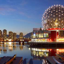

Epoch 0/3000 => Loss: 6.986


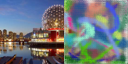

--------------------------------------------------
Epoch 100/3000 => Loss: 4.639


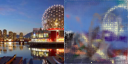

--------------------------------------------------
Epoch 200/3000 => Loss: 4.235


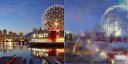

--------------------------------------------------
Epoch 300/3000 => Loss: 4.009


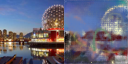

--------------------------------------------------
Epoch 400/3000 => Loss: 3.854


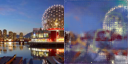

--------------------------------------------------
Epoch 500/3000 => Loss: 3.750


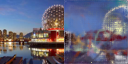

--------------------------------------------------
Epoch 600/3000 => Loss: 3.675


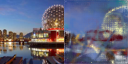

--------------------------------------------------
Epoch 700/3000 => Loss: 3.612


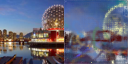

--------------------------------------------------
Epoch 800/3000 => Loss: 3.564


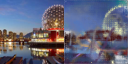

--------------------------------------------------
Epoch 900/3000 => Loss: 3.520


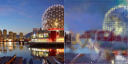

--------------------------------------------------
Epoch 1000/3000 => Loss: 3.484


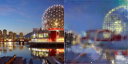

--------------------------------------------------
Epoch 1100/3000 => Loss: 3.454


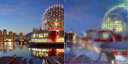

--------------------------------------------------
Epoch 1200/3000 => Loss: 3.423


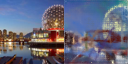

--------------------------------------------------
Epoch 1300/3000 => Loss: 3.400


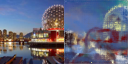

--------------------------------------------------
Epoch 1400/3000 => Loss: 3.374


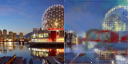

--------------------------------------------------
Epoch 1500/3000 => Loss: 3.350


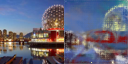

--------------------------------------------------
Epoch 1600/3000 => Loss: 3.323


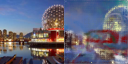

--------------------------------------------------
Epoch 1700/3000 => Loss: 3.302


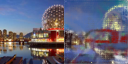

--------------------------------------------------
Epoch 1800/3000 => Loss: 3.281


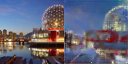

--------------------------------------------------
Epoch 1900/3000 => Loss: 3.265


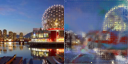

--------------------------------------------------
Epoch 2000/3000 => Loss: 3.248


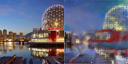

--------------------------------------------------
Epoch 2100/3000 => Loss: 3.232


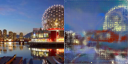

--------------------------------------------------
Epoch 2200/3000 => Loss: 3.216


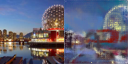

--------------------------------------------------
Epoch 2300/3000 => Loss: 3.202


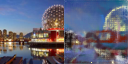

--------------------------------------------------
Epoch 2400/3000 => Loss: 3.183


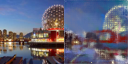

--------------------------------------------------
Epoch 2500/3000 => Loss: 3.167


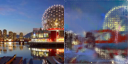

--------------------------------------------------
Epoch 2600/3000 => Loss: 3.151


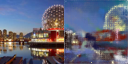

--------------------------------------------------
Epoch 2700/3000 => Loss: 3.136


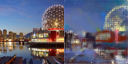

--------------------------------------------------
Epoch 2800/3000 => Loss: 3.121


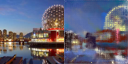

--------------------------------------------------
Epoch 2900/3000 => Loss: 3.106


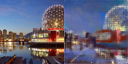

--------------------------------------------------
End of training => Loss: 3.091


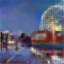


Image is saved to /content/gdrive/MyDrive/NaturalPainters/painted_images/vanc/painted_vanc_2022-02-13 06:43:56.557009_50s_3000e_4seed.png.

Image to paint is an image of louvre:


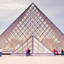

Epoch 0/3000 => Loss: 7.159


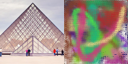

--------------------------------------------------
Epoch 100/3000 => Loss: 4.755


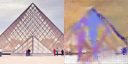

--------------------------------------------------
Epoch 200/3000 => Loss: 4.183


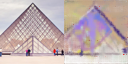

--------------------------------------------------
Epoch 300/3000 => Loss: 3.858


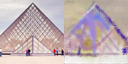

--------------------------------------------------
Epoch 400/3000 => Loss: 3.681


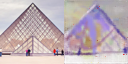

--------------------------------------------------
Epoch 500/3000 => Loss: 3.561


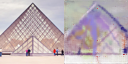

--------------------------------------------------
Epoch 600/3000 => Loss: 3.465


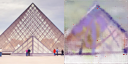

--------------------------------------------------
Epoch 700/3000 => Loss: 3.388


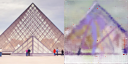

--------------------------------------------------
Epoch 800/3000 => Loss: 3.327


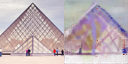

--------------------------------------------------
Epoch 900/3000 => Loss: 3.273


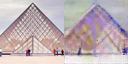

--------------------------------------------------
Epoch 1000/3000 => Loss: 3.225


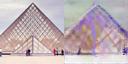

--------------------------------------------------
Epoch 1100/3000 => Loss: 3.182


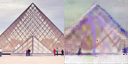

--------------------------------------------------
Epoch 1200/3000 => Loss: 3.147


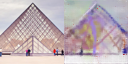

--------------------------------------------------
Epoch 1300/3000 => Loss: 3.115


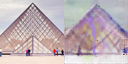

--------------------------------------------------
Epoch 1400/3000 => Loss: 3.087


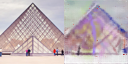

--------------------------------------------------
Epoch 1500/3000 => Loss: 3.061


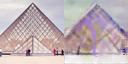

--------------------------------------------------
Epoch 1600/3000 => Loss: 3.039


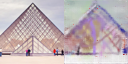

--------------------------------------------------
Epoch 1700/3000 => Loss: 3.019


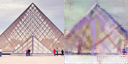

--------------------------------------------------
Epoch 1800/3000 => Loss: 3.001


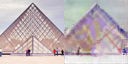

--------------------------------------------------
Epoch 1900/3000 => Loss: 2.983


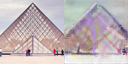

--------------------------------------------------
Epoch 2000/3000 => Loss: 2.967


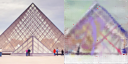

--------------------------------------------------
Epoch 2100/3000 => Loss: 2.952


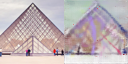

--------------------------------------------------
Epoch 2200/3000 => Loss: 2.939


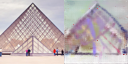

--------------------------------------------------
Epoch 2300/3000 => Loss: 2.927


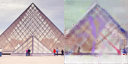

--------------------------------------------------
Epoch 2400/3000 => Loss: 2.915


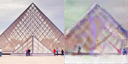

--------------------------------------------------
Epoch 2500/3000 => Loss: 2.903


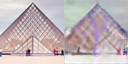

--------------------------------------------------
Epoch 2600/3000 => Loss: 2.891


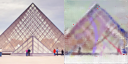

--------------------------------------------------
Epoch 2700/3000 => Loss: 2.881


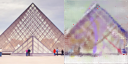

--------------------------------------------------
Epoch 2800/3000 => Loss: 2.872


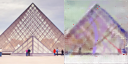

--------------------------------------------------
Epoch 2900/3000 => Loss: 2.863


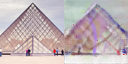

--------------------------------------------------
End of training => Loss: 2.854


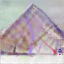


Image is saved to /content/gdrive/MyDrive/NaturalPainters/painted_images/louvre/painted_louvre_2022-02-13 06:56:00.070857_50s_3000e_4seed.png.

Image to paint is an image of eiffel:


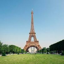

Epoch 0/3000 => Loss: 9.524


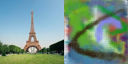

--------------------------------------------------
Epoch 100/3000 => Loss: 4.826


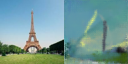

--------------------------------------------------
Epoch 200/3000 => Loss: 4.255


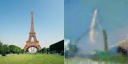

--------------------------------------------------
Epoch 300/3000 => Loss: 3.905


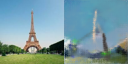

--------------------------------------------------
Epoch 400/3000 => Loss: 3.694


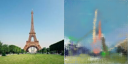

--------------------------------------------------
Epoch 500/3000 => Loss: 3.519


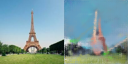

--------------------------------------------------
Epoch 600/3000 => Loss: 3.376


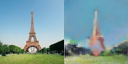

--------------------------------------------------
Epoch 700/3000 => Loss: 3.255


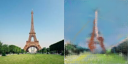

--------------------------------------------------
Epoch 800/3000 => Loss: 3.153


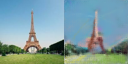

--------------------------------------------------
Epoch 900/3000 => Loss: 3.065


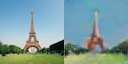

--------------------------------------------------
Epoch 1000/3000 => Loss: 2.993


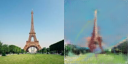

--------------------------------------------------
Epoch 1100/3000 => Loss: 2.928


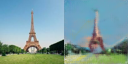

--------------------------------------------------
Epoch 1200/3000 => Loss: 2.869


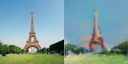

--------------------------------------------------
Epoch 1300/3000 => Loss: 2.817


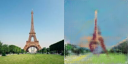

--------------------------------------------------
Epoch 1400/3000 => Loss: 2.773


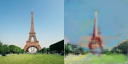

--------------------------------------------------
Epoch 1500/3000 => Loss: 2.733


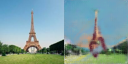

--------------------------------------------------
Epoch 1600/3000 => Loss: 2.696


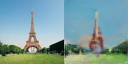

--------------------------------------------------
Epoch 1700/3000 => Loss: 2.666


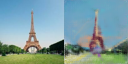

--------------------------------------------------
Epoch 1800/3000 => Loss: 2.640


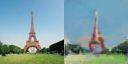

--------------------------------------------------
Epoch 1900/3000 => Loss: 2.613


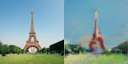

--------------------------------------------------
Epoch 2000/3000 => Loss: 2.590


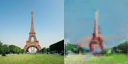

--------------------------------------------------
Epoch 2100/3000 => Loss: 2.569


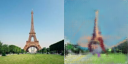

--------------------------------------------------
Epoch 2200/3000 => Loss: 2.550


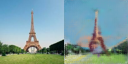

--------------------------------------------------
Epoch 2300/3000 => Loss: 2.533


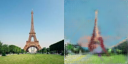

--------------------------------------------------
Epoch 2400/3000 => Loss: 2.521


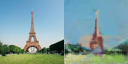

--------------------------------------------------
Epoch 2500/3000 => Loss: 2.506


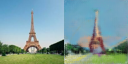

--------------------------------------------------
Epoch 2600/3000 => Loss: 2.492


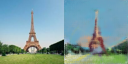

--------------------------------------------------
Epoch 2700/3000 => Loss: 2.478


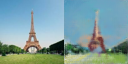

--------------------------------------------------
Epoch 2800/3000 => Loss: 2.465


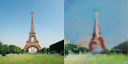

--------------------------------------------------
Epoch 2900/3000 => Loss: 2.453


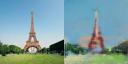

--------------------------------------------------
End of training => Loss: 2.443


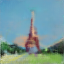


Image is saved to /content/gdrive/MyDrive/NaturalPainters/painted_images/eiffel/painted_eiffel_2022-02-13 07:08:06.098947_50s_3000e_4seed.png.

Image to paint is an image of castle:


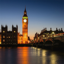

Epoch 0/3000 => Loss: 7.699


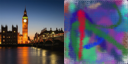

--------------------------------------------------
Epoch 100/3000 => Loss: 4.698


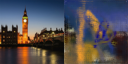

--------------------------------------------------
Epoch 200/3000 => Loss: 4.240


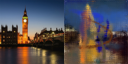

--------------------------------------------------
Epoch 300/3000 => Loss: 3.928


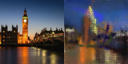

--------------------------------------------------
Epoch 400/3000 => Loss: 3.713


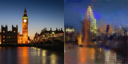

--------------------------------------------------
Epoch 500/3000 => Loss: 3.556


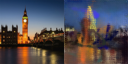

--------------------------------------------------
Epoch 600/3000 => Loss: 3.440


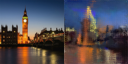

--------------------------------------------------
Epoch 700/3000 => Loss: 3.358


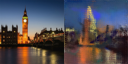

--------------------------------------------------
Epoch 800/3000 => Loss: 3.287


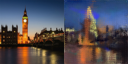

--------------------------------------------------
Epoch 900/3000 => Loss: 3.235


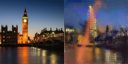

--------------------------------------------------
Epoch 1000/3000 => Loss: 3.195


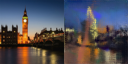

--------------------------------------------------
Epoch 1100/3000 => Loss: 3.156


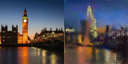

--------------------------------------------------
Epoch 1200/3000 => Loss: 3.121


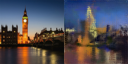

--------------------------------------------------
Epoch 1300/3000 => Loss: 3.090


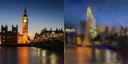

--------------------------------------------------
Epoch 1400/3000 => Loss: 3.062


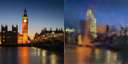

--------------------------------------------------
Epoch 1500/3000 => Loss: 3.039


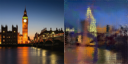

--------------------------------------------------
Epoch 1600/3000 => Loss: 3.018


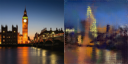

--------------------------------------------------
Epoch 1700/3000 => Loss: 2.997


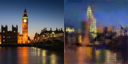

--------------------------------------------------
Epoch 1800/3000 => Loss: 2.982


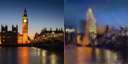

--------------------------------------------------
Epoch 1900/3000 => Loss: 2.965


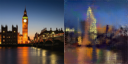

--------------------------------------------------
Epoch 2000/3000 => Loss: 2.952


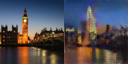

--------------------------------------------------
Epoch 2100/3000 => Loss: 2.937


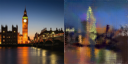

--------------------------------------------------
Epoch 2200/3000 => Loss: 2.924


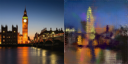

--------------------------------------------------
Epoch 2300/3000 => Loss: 2.910


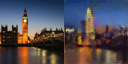

--------------------------------------------------
Epoch 2400/3000 => Loss: 2.896


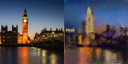

--------------------------------------------------
Epoch 2500/3000 => Loss: 2.881


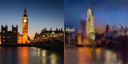

--------------------------------------------------
Epoch 2600/3000 => Loss: 2.871


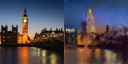

--------------------------------------------------
Epoch 2700/3000 => Loss: 2.861


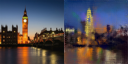

--------------------------------------------------
Epoch 2800/3000 => Loss: 2.852


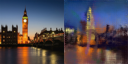

--------------------------------------------------
Epoch 2900/3000 => Loss: 2.844


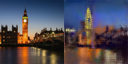

--------------------------------------------------
End of training => Loss: 2.836


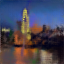


Image is saved to /content/gdrive/MyDrive/NaturalPainters/painted_images/castle/painted_castle_2022-02-13 07:20:07.314835_50s_3000e_4seed.png.


In [166]:
torch.manual_seed(SEED)

collection_of_histories = {} # dictionary of dictionaries
collection_of_canvas_evolutions = [] # list of lists: final canvas painted stroke by stroke for each source image
collection_of_train_evolutions = [] # lits of lists: development of final canvases with training stage for each source image

for img_path in image_path_list:

    img_to_paint_name, img_to_paint, img_to_paint_tensor = generate_source_to_paint(img_path)

    # initialize actions randomly with U[0,1]
    # shape is (desired_number_of_strokes, 12) 
    actions = torch.empty((hparams.in_strokes, hparams.in_features), device = device).uniform_().requires_grad_(True)

    optimizer = optim.RMSprop([actions], lr = hparams.lr)  

    trainer = Trainer(generator,
                      feature_extractor,
                      optimizer,
                      img_to_paint_tensor = img_to_paint_tensor,
                      epochs = hparams.epochs,
                      gpu = gpu)  
    
    timestamp = str(datetime.datetime.now()).strip()
    train_history = trainer.train(actions, 
                                  save_img_path = save_images_path + img_to_paint_name + '/painted_' 
                                  + img_to_paint_name + '_' + timestamp + f'_{hparams.in_strokes}s_{hparams.epochs}e_{SEED}seed.png',
                                  print_interval = hparams.print_interval)
  
    collection_of_histories[img_to_paint_name] = train_history

    final_canvas_evolution = trainer.save_frames(save_frames_path = save_images_path + img_to_paint_name + '/frames/' 
                                                 + img_to_paint_name + '_' + timestamp + '_', only_final = True)
    
    train_canvas_evolution = trainer.save_frames(save_frames_path = save_images_path + img_to_paint_name + '/train_frames/' 
                                                 + img_to_paint_name + '_' + timestamp + '_', only_final = False)
    
    collection_of_canvas_evolutions.append(final_canvas_evolution)
    collection_of_train_evolutions.append(train_canvas_evolution)

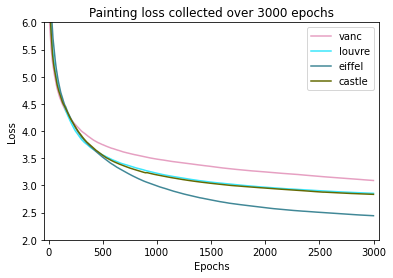

In [185]:
# plot and save train loss
fig, axs = plt.subplots()
legend_list = []
for (key, value) in collection_of_histories.items():
    plt.plot(value['mean_train_loss'], '-', color = (random.random(), random.random(), random.random()))
    legend_list.append(key)
plt.title(f'Painting loss collected over {hparams.epochs} epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xlim([-40, 3050])
plt.ylim([2, 6])
plt.legend(legend_list, loc='upper right')
fig.savefig(plots_path + f'paint_{hparams.in_strokes}s_{hparams.epochs}e_{SEED}seed_{timestamp}t.png', bbox_inches = 'tight')
plt.show()

# **Making video**

In [218]:
def animate(img_to_paint_tensor, final_canvas_evolution):
    for cur_canvas in final_canvas_evolution:
        stacked_img = torch.cat((img_to_paint_tensor.clone().cpu(), to_tensor(cur_canvas)), dim = 2)
        display(to_pil_image(stacked_img))
        time.sleep(hparams.secs)
        clear_output(wait = True)

def rename_frames(path_to_frames, img_to_paint_name):
    for old_name in glob.glob(path_to_frames):
        new_name = old_name.split(img_to_paint_name)
        new_name[-1] = img_to_paint_name + '_' + new_name[-1].split('_')[-1]
        new_name[0] += img_to_paint_name
        new_name = ''.join(new_name)
        os.rename(old_name, new_name)
        
train_videopaths = []
final_videopaths = []

## **Vancouver**

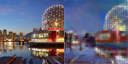

In [219]:
# animated vancouver painting
img_to_paint_name, _, img_to_paint_tensor = generate_source_to_paint(image_path_list[0])
#rename_frames(save_images_path + img_to_paint_name + '/frames/last_timestamp/*', img_to_paint_name)
frames_path = save_images_path + img_to_paint_name + '/frames/last_timestamp/' + img_to_paint_name + '_%03d.png'
video_path = save_images_path + img_to_paint_name + '/' + img_to_paint_name + '_final.mp4'
final_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_canvas_evolutions[0])

In [220]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

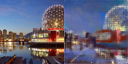

In [225]:
#rename_frames(save_images_path + img_to_paint_name + '/train_frames/*', img_to_paint_name)
frames_path = save_images_path + img_to_paint_name + '/train_frames/' + img_to_paint_name + '_%03d.png'
video_path = save_images_path + img_to_paint_name + '/' + img_to_paint_name + '_train.mp4'
train_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_train_evolutions[0])

In [226]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

## **Louvre**

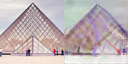

In [227]:
# animated louvre painting
img_to_paint_name, _, img_to_paint_tensor = generate_source_to_paint(image_path_list[1])
#rename_frames(save_images_path + img_to_paint_name + '/frames/last_timestamp/*', img_to_paint_name)
frames_path = save_images_path + img_to_paint_name + '/frames/last_timestamp/' + img_to_paint_name + '_%03d.png'
video_path = save_images_path + img_to_paint_name + '/' + img_to_paint_name + '_final.mp4'
final_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_canvas_evolutions[1])

In [228]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

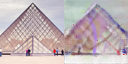

In [232]:
#rename_frames(save_images_path + img_to_paint_name + '/train_frames/*', img_to_paint_name)
frames_path = save_images_path + img_to_paint_name + '/train_frames/' + img_to_paint_name + '_%03d.png'
video_path = save_images_path + img_to_paint_name + '/' + img_to_paint_name + '_train.mp4'
train_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_train_evolutions[1])

In [233]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

## **Eiffel**

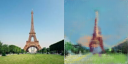

In [240]:
# animated eiffel painting
img_to_paint_name, _, img_to_paint_tensor = generate_source_to_paint(image_path_list[2])
#rename_frames(save_images_path + img_to_paint_name + '/frames/last_timestamp/*', img_to_paint_name)
frames_path = save_images_path + img_to_paint_name + '/frames/last_timestamp/' + img_to_paint_name + '_%03d.png'
video_path = save_images_path + img_to_paint_name + '/' + img_to_paint_name + '_final.mp4'
final_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_canvas_evolutions[2])

In [241]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

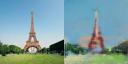

In [242]:
#rename_frames(save_images_path + img_to_paint_name + '/train_frames/*', img_to_paint_name)
frames_path = save_images_path + img_to_paint_name + '/train_frames/' + img_to_paint_name + '_%03d.png'
video_path = save_images_path + img_to_paint_name + '/' + img_to_paint_name + '_train.mp4'
train_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_train_evolutions[2])

In [243]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

## **Castle**

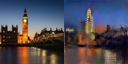

In [244]:
# animated castle painting
img_to_paint_name, _, img_to_paint_tensor = generate_source_to_paint(image_path_list[3])
#rename_frames(save_images_path + img_to_paint_name + '/frames/last_timestamp/*', img_to_paint_name)
frames_path = save_images_path + img_to_paint_name + '/frames/last_timestamp/' + img_to_paint_name + '_%03d.png'
video_path = save_images_path + img_to_paint_name + '/' + img_to_paint_name + '_final.mp4'
final_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_canvas_evolutions[3])

In [245]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

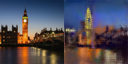

In [246]:
#rename_frames(save_images_path + img_to_paint_name + '/train_frames/*', img_to_paint_name)
frames_path = save_images_path + img_to_paint_name + '/train_frames/' + img_to_paint_name + '_%03d.png'
video_path = save_images_path + img_to_paint_name + '/' + img_to_paint_name + '_train.mp4'
train_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_train_evolutions[3])

In [247]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

## **Video gallery**

In [248]:
html_str=""
for filepath in set(train_videopaths):
  mp4 = open(filepath,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  html_str += """
  <video width=128 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
HTML(html_str)

In [249]:
html_str=""
for filepath in set(final_videopaths):
  mp4 = open(filepath,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  html_str += """
  <video width=128 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
HTML(html_str)